In [1]:
modelName = 'vgg16_bn-32'
filterName = 'None'

point = 'Point1'

In [2]:
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

from torchvision import models
from torchvision import transforms
from torchvision.io import read_image

import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split

from tqdm import tqdm

import random
import os, sys

sys.path.append('../add/')

from vgg import Custom_VGG

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

torch.backends.cudnn.deterministic = True

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
class CustomImageDataset(Dataset):
    def __init__(self, df, transform=None):

        self.df = df
        
        self.device = device
        
        self.transform = transform

    def __len__(self):
        return len(self.df)


    def __getitem__(self, idx):
        if idx >= len(self): raise StopIteration

        img = read_image(self.df.loc[idx, 'img_path'])[:3,:,:]
        filename = self.df.loc[idx, 'filename']
        sign = self.df.loc[idx, 'sign']
        
        if self.transform:
            img = self.transform(img)

        return img, filename, sign
    
    def getData(self):
        return list(self)

In [7]:
def createDataFrame():
    
    train_df = pd.read_csv('../../data/train.csv')
    train_df['img_path'] = '../../data/avia-train/avia-train/' + train_df['filename'] + '.png'
    
    test_df = pd.read_csv('../../data/test.csv')
    test_df['img_path'] = '../../data/avia-test/avia-test/' + test_df['filename'] + '.png'
    test_df['sign'] = -1
    
    test_e_df = pd.read_csv('../../data/test_extended.csv', index_col='filename')
    
    test_e_df = test_e_df.drop(test_df['filename'])
    test_e_df['filename'] = test_e_df.index
    
    test_e_df['img_path'] = '../../data/avia-test-extended/avia-test-extended/' + test_e_df['filename'] + '.jpeg'
    test_e_df['sign'] = -1
    
    df = pd.concat((train_df, test_df, test_e_df)).reset_index(drop=True)
    
    df['sign'] = df['sign'].astype('float64')
    
    return df

In [8]:
def createDataLoader(df, batch_size=None, shuffle=False, transform=None):

    batch_size = batch_size if batch_size else len(df)
    
    dataset = CustomImageDataset(df, transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    
    return dataset, dataloader

In [9]:
df = createDataFrame()

In [10]:
model = Custom_VGG(pretrained=True, vgg_type='vgg16_bn', ipt_size=(32, 32), num_classes=1)


weight = torch.tensor([sum(df['sign'] == 1) / sum(df['sign'] != -1)])
criterion = nn.BCELoss(weight=weight, reduction='mean')
criterion.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [11]:
%%time

def f():
    log = {'loss': {'train': [], 'val': []}, 'bestEpoch':0}
    
    epochs = 15
    
    train_df, val_df = train_test_split(df[df['sign'] != -1], test_size=0.2, random_state=42)
    train_df, val_df = train_df.reset_index(drop=True), val_df.reset_index(drop=True)
    
    traintransform = transforms.Compose([
        transforms.Resize(32),
        transforms.ToPILImage(),

        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),

        transforms.ToTensor(),
    ])
    _, train_dataloader = createDataLoader(train_df, batch_size=300, shuffle=True, transform=traintransform)
    
    valTransform = transforms.Compose([
        transforms.Resize(32),
        transforms.ToPILImage(),

        transforms.ToTensor(),
    ])
    _, val_dataloader = createDataLoader(val_df, batch_size=150, shuffle=True, transform=valTransform)
    
    
    model.to(device)
    
    for epoch in range(epochs):
        # Train
        model.train()
        running_loss = 0
        for X, _, y in train_dataloader:
            optimizer.zero_grad()

            X, y = X.to(device), y.to(device).float().reshape(-1, 1)

            y_predict = model(X)
            
            loss = criterion(y_predict, y)
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
        log['loss']['train'].append(running_loss/len(train_dataloader))
        
        # Val
        model.eval()
        running_loss = 0
        for X, _, y in val_dataloader:

            X, y = X.to(device), y.to(device).float()

            y_predicted1 = model(X)
            y_predicted2 = model(transforms.RandomHorizontalFlip(p=1)(X))
            y_predicted3 = model(transforms.RandomVerticalFlip(p=1)(X))
            y_predicted4 = model(transforms.RandomVerticalFlip(p=1)(transforms.RandomHorizontalFlip(p=1)(X)))

            y_predict = torch.cat((y_predicted1, y_predicted2, y_predicted3, y_predicted4), dim=1).mean(dim=1)

            loss = criterion(y_predict, y)
            running_loss += loss.item()


        log['loss']['val'].append(running_loss/len(val_dataloader))

        if not log['bestEpoch'] or log['loss']['val'][-1] < min(log['loss']['val'][:-1]):
            torch.save(model.state_dict(), f'./models/{modelName}_{filterName}_{point}.pt')
            log['bestEpoch'] = epoch

        print(f"Epoch: {epoch+1} / {epochs} | Train loss: {log['loss']['train'][-1]} | Val loss: {log['loss']['val'][-1]}")
            
    return log
        
log = f()    

Epoch: 1 / 15 | Train loss: 0.06312773637024753 | Val loss: 0.04867409036627838
Epoch: 2 / 15 | Train loss: 0.04263443591813725 | Val loss: 0.026829670360755353
Epoch: 3 / 15 | Train loss: 0.014477304497127792 | Val loss: 0.007019721570291689
Epoch: 4 / 15 | Train loss: 0.006508915115663984 | Val loss: 0.00570047947500522
Epoch: 5 / 15 | Train loss: 0.0056313137153545054 | Val loss: 0.0052899282641841894
Epoch: 6 / 15 | Train loss: 0.004385879484190415 | Val loss: 0.0042768582366296045
Epoch: 7 / 15 | Train loss: 0.003728326406548675 | Val loss: 0.0033053929122009626
Epoch: 8 / 15 | Train loss: 0.0027753715852208167 | Val loss: 0.0037422049125390394
Epoch: 9 / 15 | Train loss: 0.0025597257344669336 | Val loss: 0.0034919276329760792
Epoch: 10 / 15 | Train loss: 0.00396380136795875 | Val loss: 0.0036707450621872254
Epoch: 11 / 15 | Train loss: 0.002620449188692742 | Val loss: 0.003992074581522805
Epoch: 12 / 15 | Train loss: 0.00219347554624378 | Val loss: 0.003564416430197612
Epoch: 13 

In [12]:
print(log['bestEpoch'])

fig = plt.figure()
axes = fig.add_axes([1, 1, 2, 2])

axes.plot(range(len(log['loss']['train'])), log['loss']['train'], 'b')
axes.plot(range(len(log['loss']['val'])), log['loss']['val'], 'r')
plt.show()

6


In [13]:
model = Custom_VGG(pretrained=True, vgg_type='vgg16_bn', ipt_size=(32, 32), num_classes=1)

model.load_state_dict(torch.load(f'./models/{modelName}_{filterName}_{point}.pt'))

<All keys matched successfully>

In [14]:
%%time
with torch.no_grad():
    model.eval()
    model.to(device)

    test_df = df.copy()
    test_df = test_df.reset_index(drop=True)
    
    testTransform = transforms.Compose([
        transforms.Resize(32),
        transforms.ToPILImage(),

        transforms.ToTensor(),
    ])
    _, test_dataloader = createDataLoader(test_df, batch_size=200, shuffle=True, transform=testTransform)
    
    filenames = []
    sign = []
    predicteds = [[], [], [], []]
    
    for X, filename, y in test_dataloader:

        X = X.to(device)
        
        predicteds[0].append(model(X).reshape(-1).cpu())
        predicteds[1].append(model(transforms.RandomHorizontalFlip(p=1)(X)).reshape(-1).cpu())
        predicteds[2].append(model(transforms.RandomVerticalFlip(p=1)(X)).reshape(-1).cpu())
        predicteds[3].append(model(transforms.RandomVerticalFlip(p=1)(transforms.RandomHorizontalFlip(p=1)(X))).reshape(-1).cpu())
        
        sign.append(y)
        filenames += filename
        
predicteds[0] = torch.cat(predicteds[0], 0)
predicteds[1] = torch.cat(predicteds[1], 0)
predicteds[2] = torch.cat(predicteds[2], 0)
predicteds[3] = torch.cat(predicteds[3], 0)

sign = torch.cat(sign)

Wall time: 4min 16s


In [15]:
predict_df1 = pd.DataFrame({
    'filename': filenames,
    'model': modelName,
    'filter': filterName,
    'point': point,
    'v': 0,
    
    'predict': predicteds[0],
    'sign': sign,
})

predict_df2 = pd.DataFrame({
    'filename': filenames,
    'model': modelName,
    'filter': filterName,
    'point': point,
    'v': 1,
    
    'predict': predicteds[1],
    'sign': sign,
})

predict_df3 = pd.DataFrame({
    'filename': filenames,
    'model': modelName,
    'filter': filterName,
    'point': point,
    'v': 2,
    
    'predict': predicteds[2],
    'sign': sign,
})

predict_df4 = pd.DataFrame({
    'filename': filenames,
    'model': modelName,
    'filter': filterName,
    'point': point,
    'v': 3,
    
    'predict': predicteds[3],
    'sign': sign,
})

In [16]:
predict_df = pd.concat((predict_df1, predict_df2, predict_df3, predict_df4)).reset_index(drop=True)
predict_df

filename        model filter   point  v  \
0       57554f24-910e-4b74-bc68-9ea75ee7aadb  vgg16_bn-32   None  Point1  0   
1       42c603c0-2957-40d4-b520-b68bd3fa5b05  vgg16_bn-32   None  Point1  0   
2       4d226974-afb2-4ea0-a39e-262df808a8f8  vgg16_bn-32   None  Point1  0   
3       418c81dd-f7f0-420e-9872-3f84118a59ff  vgg16_bn-32   None  Point1  0   
4       5a2b8fff-364d-44db-b353-0625a94200f4  vgg16_bn-32   None  Point1  0   
...                                      ...          ...    ...     ... ..   
528315  ebdfcc1f-cc06-4322-8d03-498b31e549f4  vgg16_bn-32   None  Point1  3   
528316  3bf851e7-63c0-4132-acc5-639f2da780ac  vgg16_bn-32   None  Point1  3   
528317  25b05fe8-d622-494c-9bf3-874dc3717d1f  vgg16_bn-32   None  Point1  3   
528318  f19de3e7-6ddd-421e-814d-969e5325af65  vgg16_bn-32   None  Point1  3   
528319  307bba44-0fac-414f-ac05-d984bf9e39df  vgg16_bn-32   None  Point1  3   

             predict  sign  
0       6.377359e-05  -1.0  
1       9.967617e-01   1.0  
2       2.799882e-05  -1.0  
3       1.154795e-04  -1.0  
4       1.054975e-04  -1.0  
...              ...   ...  
528315  4.769642e-04  -1.0  
528316  4.444539e-05  -1.0  
528317  2.125719e-08   0.0  
528318  5.873750e-05  -1.0  
528319  2.929472e-07   0.0  

[528320 rows x 7 columns]

In [17]:
predict_df.to_csv(f'predicteds/{modelName}_{filterName}_{point}.csv', index=False)

In [18]:
modelName = 'vgg16_bn-32'
filterName = 'None'
point = 'Point2'

pointLoad = 'Point1'

In [19]:
model = Custom_VGG(pretrained=True, vgg_type='vgg16_bn', ipt_size=(32, 32), num_classes=1)

model.load_state_dict(torch.load(f'./models/{modelName}_{filterName}_{pointLoad}.pt'))

weight = torch.tensor([sum(df['sign'] == 1) / sum(df['sign'] != -1)])
criterion = nn.BCELoss(weight=weight, reduction='mean')
criterion.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.000001)

In [20]:
%%time

def f():
    log = {'loss': {'train': [], 'val': []}, 'bestEpoch':0}
    
    epochs = 15
    
    train_df, val_df = train_test_split(df[df['sign'] != -1], test_size=0.2, random_state=42)
    train_df, val_df = train_df.reset_index(drop=True), val_df.reset_index(drop=True)
    
    traintransform = transforms.Compose([
        transforms.Resize(32),
        transforms.ToPILImage(),

        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),

        transforms.ToTensor(),
    ])
    _, train_dataloader = createDataLoader(train_df, batch_size=300, shuffle=True, transform=traintransform)
    
    valTransform = transforms.Compose([
        transforms.Resize(32),
        transforms.ToPILImage(),

        transforms.ToTensor(),
    ])
    _, val_dataloader = createDataLoader(val_df, batch_size=150, shuffle=True, transform=valTransform)
    
    
    model.to(device)
    
    for epoch in range(epochs):
        # Train
        model.train()
        running_loss = 0
        for X, _, y in train_dataloader:
            optimizer.zero_grad()

            X, y = X.to(device), y.to(device).float().reshape(-1, 1)

            y_predict = model(X)
            
            loss = criterion(y_predict, y)
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
        log['loss']['train'].append(running_loss/len(train_dataloader))
        
        # Val
        model.eval()
        running_loss = 0
        for X, _, y in val_dataloader:

            X, y = X.to(device), y.to(device).float()

            y_predicted1 = model(X)
            y_predicted2 = model(transforms.RandomHorizontalFlip(p=1)(X))
            y_predicted3 = model(transforms.RandomVerticalFlip(p=1)(X))
            y_predicted4 = model(transforms.RandomVerticalFlip(p=1)(transforms.RandomHorizontalFlip(p=1)(X)))

            y_predict = torch.cat((y_predicted1, y_predicted2, y_predicted3, y_predicted4), dim=1).mean(dim=1)

            loss = criterion(y_predict, y)
            running_loss += loss.item()


        log['loss']['val'].append(running_loss/len(val_dataloader))

        if not log['bestEpoch'] or log['loss']['val'][-1] < min(log['loss']['val'][:-1]):
            torch.save(model.state_dict(), f'./models/{modelName}_{filterName}_{point}.pt')
            log['bestEpoch'] = epoch

        print(f"Epoch: {epoch+1} / {epochs} | Train loss: {log['loss']['train'][-1]} | Val loss: {log['loss']['val'][-1]}")
            
    return log
        
log = f()    

Epoch: 1 / 15 | Train loss: 0.0028319217374054603 | Val loss: 0.0031612477961018505
Epoch: 2 / 15 | Train loss: 0.002341428529667522 | Val loss: 0.003032048938621301
Epoch: 3 / 15 | Train loss: 0.0024266029639360325 | Val loss: 0.00301735872164413
Epoch: 4 / 15 | Train loss: 0.002230576901200104 | Val loss: 0.002947968049695538
Epoch: 5 / 15 | Train loss: 0.0020927701496760397 | Val loss: 0.0029265858535100484
Epoch: 6 / 15 | Train loss: 0.0020358095247809023 | Val loss: 0.0028779970044048413
Epoch: 7 / 15 | Train loss: 0.002243984137529911 | Val loss: 0.0028473359305367226
Epoch: 8 / 15 | Train loss: 0.002049105109700215 | Val loss: 0.0028751513198672215
Epoch: 9 / 15 | Train loss: 0.0022765088497509575 | Val loss: 0.002792716364464944
Epoch: 10 / 15 | Train loss: 0.00183579143654297 | Val loss: 0.0028392028110656178
Epoch: 11 / 15 | Train loss: 0.00202208783629025 | Val loss: 0.002870651722852407
Epoch: 12 / 15 | Train loss: 0.0018715861972971224 | Val loss: 0.0027742708099096837
Epo

12


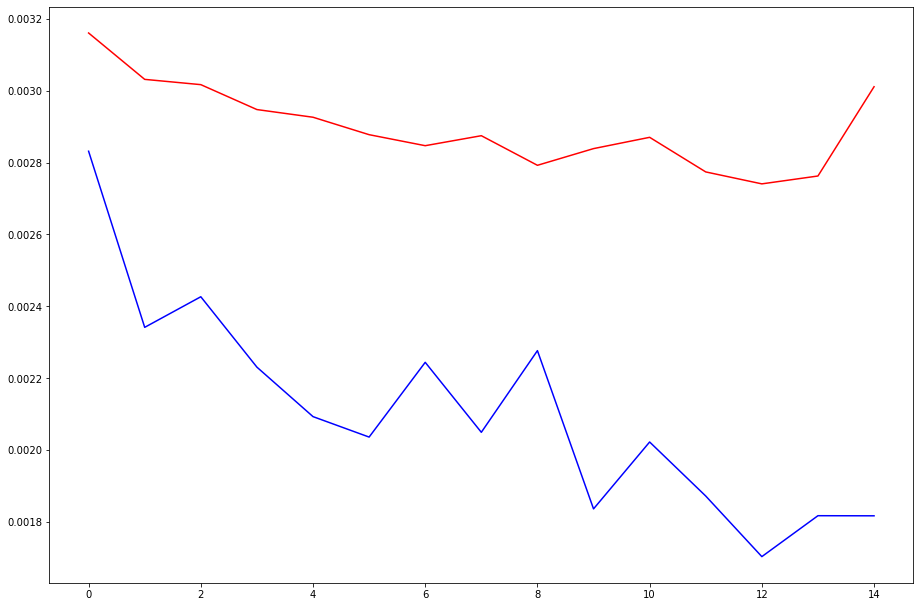

In [21]:
print(log['bestEpoch'])

fig = plt.figure()
axes = fig.add_axes([1, 1, 2, 2])

axes.plot(range(len(log['loss']['train'])), log['loss']['train'], 'b')
axes.plot(range(len(log['loss']['val'])), log['loss']['val'], 'r')
plt.show()

In [22]:
model = Custom_VGG(pretrained=True, vgg_type='vgg16_bn', ipt_size=(32, 32), num_classes=1)

model.load_state_dict(torch.load(f'./models/{modelName}_{filterName}_{point}.pt'))

<All keys matched successfully>

In [23]:
%%time
with torch.no_grad():
    model.eval()
    model.to(device)

    test_df = df.copy()
    test_df = test_df.reset_index(drop=True)
    
    testTransform = transforms.Compose([
        transforms.Resize(32),
        transforms.ToPILImage(),

        transforms.ToTensor(),
    ])
    _, test_dataloader = createDataLoader(test_df, batch_size=200, shuffle=True, transform=testTransform)
    
    filenames = []
    sign = []
    predicteds = [[], [], [], []]
    
    for X, filename, y in test_dataloader:

        X = X.to(device)
        
        predicteds[0].append(model(X).reshape(-1).cpu())
        predicteds[1].append(model(transforms.RandomHorizontalFlip(p=1)(X)).reshape(-1).cpu())
        predicteds[2].append(model(transforms.RandomVerticalFlip(p=1)(X)).reshape(-1).cpu())
        predicteds[3].append(model(transforms.RandomVerticalFlip(p=1)(transforms.RandomHorizontalFlip(p=1)(X))).reshape(-1).cpu())
        
        sign.append(y)
        filenames += filename
        
predicteds[0] = torch.cat(predicteds[0], 0)
predicteds[1] = torch.cat(predicteds[1], 0)
predicteds[2] = torch.cat(predicteds[2], 0)
predicteds[3] = torch.cat(predicteds[3], 0)

sign = torch.cat(sign)

Wall time: 4min 20s


In [24]:
predict_df1 = pd.DataFrame({
    'filename': filenames,
    'model': modelName,
    'filter': filterName,
    'point': point,
    'v': 0,
    
    'predict': predicteds[0],
    'sign': sign,
})

predict_df2 = pd.DataFrame({
    'filename': filenames,
    'model': modelName,
    'filter': filterName,
    'point': point,
    'v': 1,
    
    'predict': predicteds[1],
    'sign': sign,
})

predict_df3 = pd.DataFrame({
    'filename': filenames,
    'model': modelName,
    'filter': filterName,
    'point': point,
    'v': 2,
    
    'predict': predicteds[2],
    'sign': sign,
})

predict_df4 = pd.DataFrame({
    'filename': filenames,
    'model': modelName,
    'filter': filterName,
    'point': point,
    'v': 3,
    
    'predict': predicteds[3],
    'sign': sign,
})

In [25]:
predict_df = pd.concat((predict_df1, predict_df2, predict_df3, predict_df4)).reset_index(drop=True)
predict_df

filename        model filter   point  v  \
0       caa0262d-64de-47f4-a8a0-60dda6fa69c1  vgg16_bn-32   None  Point2  0   
1       81caf1ad-7ca9-4ab5-9eff-24bc3cbade90  vgg16_bn-32   None  Point2  0   
2       e8e20946-bb7d-4541-b321-cea3de3d7bf6  vgg16_bn-32   None  Point2  0   
3       8cbd2709-413f-4081-bcac-568d3541da66  vgg16_bn-32   None  Point2  0   
4       e8e100e1-b1be-4e81-a9e6-ae93e9795e50  vgg16_bn-32   None  Point2  0   
...                                      ...          ...    ...     ... ..   
528315  2ef7033b-78d6-4d7e-a3f0-e97834527c58  vgg16_bn-32   None  Point2  3   
528316  03c846ab-3370-4ade-959f-5429314613c5  vgg16_bn-32   None  Point2  3   
528317  8d449563-65a3-48a0-b373-e59061a99402  vgg16_bn-32   None  Point2  3   
528318  063256c2-534c-4ee2-a370-1162ab6be17f  vgg16_bn-32   None  Point2  3   
528319  987b40a3-fb26-495b-99ae-6142b6133734  vgg16_bn-32   None  Point2  3   

         predict  sign  
0       0.000022  -1.0  
1       0.000063  -1.0  
2       0.000012  -1.0  
3       0.000016   0.0  
4       0.000013  -1.0  
...          ...   ...  
528315  0.000004  -1.0  
528316  0.000014  -1.0  
528317  0.000086  -1.0  
528318  0.000030  -1.0  
528319  0.000053  -1.0  

[528320 rows x 7 columns]

In [26]:
predict_df.to_csv(f'predicteds/{modelName}_{filterName}_{point}.csv', index=False)